In [1]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

### Alistamiento de datos para entrenamiento de modelo

In [2]:
# Cargue de datos
df = pd.read_csv("data/train_40k.csv")

In [3]:
df.describe()

,Score,Time
count,40000.000000,4.000000e+04
mean,4.070175,1.235878e+09
std,1.357091,8.555040e+07
min,1.000000,-1.000000e+00
25%,4.000000,1.183162e+09
50%,5.000000,1.254010e+09
75%,5.000000,1.307318e+09
max,5.000000,1.344211e+09


In [5]:
df.dtypes

productId        object
Title            object
userId           object
Helpfulness      object
Score           float64
Time              int64
Text             object
Cat1           category
Cat2             object
Cat3             object
dtype: object

In [4]:
df['Cat1'] = df['Cat1'].astype('category')

In [6]:
df.rename(columns={'Cat1': 'Category'}, inplace=True)

In [7]:
df['Category'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
39995    False
39996    False
39997    False
39998    False
39999    False
Name: Category, Length: 40000, dtype: bool

In [9]:
df.groupby('Category').agg('count')

C:\Users\User\AppData\Local\Temp\ipykernel_8856\932829584.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Category').agg('count')


,productId,Title,userId,Helpfulness,Score,Time,Text,Cat2,Cat3
Category,,,,,,,,,
baby products,5637,5637,5637,5637,5637,5637,5637,5637,5637
beauty,5846,5843,5846,5846,5846,5846,5846,5846,5846
grocery gourmet food,3617,3616,3617,3617,3617,3617,3617,3617,3617
health personal care,9772,9761,9772,9772,9772,9772,9772,9772,9772
pet supplies,4862,4861,4862,4862,4862,4862,4862,4862,4862
toys games,10266,10266,10266,10266,10266,10266,10266,10266,10266


In [10]:
df['Category'].unique()

['grocery gourmet food', 'toys games', 'beauty', 'health personal care', 'baby products', 'pet supplies']
Categories (6, object): ['baby products', 'beauty', 'grocery gourmet food', 'health personal care', 'pet supplies', 'toys games']

In [11]:
standard_categories = {
   'baby products': 'Baby',
    'beauty': 'Beauty',
    'grocery gourmet food': 'Food',
    'health personal care': 'Health and personal care',
    'pet supplies': 'Pet supplies',
    'toys games': 'Toys and games'
}

In [12]:
df['Category'] = df['Category'].replace(standard_categories)

In [13]:
df['Category'].unique()

['Food', 'Toys and games', 'Beauty', 'Health and personal care', 'Baby', 'Pet supplies']
Categories (6, object): ['Baby', 'Beauty', 'Food', 'Health and personal care', 'Pet supplies', 'Toys and games']

In [14]:
# Lista de categorias de Amazon
categories = [
   'Baby',
    'Beauty',
    'Food',
    'Health and personal care',
    'Pet supplies',
    'Toys and games'
]

In [15]:
# Separación del dataset en entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Title'].tolist(), df['Category'].tolist(), test_size=0.2, random_state=42
)

In [16]:
print(train_labels[:10])
print(val_labels[:10])

['Pet supplies', 'Beauty', 'Toys and games', 'Food', 'Health and personal care', 'Toys and games', 'Toys and games', 'Pet supplies', 'Health and personal care', 'Toys and games']
['Health and personal care', 'Health and personal care', 'Health and personal care', 'Health and personal care', 'Toys and games', 'Food', 'Toys and games', 'Toys and games', 'Toys and games', 'Baby']


In [17]:
print(df['Category'].unique())

['Food', 'Toys and games', 'Beauty', 'Health and personal care', 'Baby', 'Pet supplies']
Categories (6, object): ['Baby', 'Beauty', 'Food', 'Health and personal care', 'Pet supplies', 'Toys and games']


In [18]:
# Incializar LabelEncoder
label_encoder = LabelEncoder()

In [19]:
# Convertir labels de string a numero
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [20]:
print(set(train_labels_encoded))
print(set(val_labels_encoded))

{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [21]:
print(set(train_labels))
print(set(val_labels))

{'Health and personal care', 'Pet supplies', 'Beauty', 'Toys and games', 'Baby', 'Food'}
{'Health and personal care', 'Pet supplies', 'Beauty', 'Toys and games', 'Baby', 'Food'}


In [22]:
# Imprimir los primeros elementos de train_labels y val_labels
print(train_labels[:10])  
print(val_labels[:10])    


['Pet supplies', 'Beauty', 'Toys and games', 'Food', 'Health and personal care', 'Toys and games', 'Toys and games', 'Pet supplies', 'Health and personal care', 'Toys and games']
['Health and personal care', 'Health and personal care', 'Health and personal care', 'Health and personal care', 'Toys and games', 'Food', 'Toys and games', 'Toys and games', 'Toys and games', 'Baby']


In [23]:
# Comprobar el mapeo de labels originales y codificados
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Baby': 0, 'Beauty': 1, 'Food': 2, 'Health and personal care': 3, 'Pet supplies': 4, 'Toys and games': 5}


### Tokenización

In [24]:
# Cargue del tokenizador y modelo DistilBERT 
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Con train_texts y val_texts siendo listas de pandas
train_texts = train_texts.tolist() if isinstance(train_texts, pd.Series) else train_texts
val_texts = val_texts.tolist() if isinstance(val_texts, pd.Series) else val_texts

In [25]:
# Comprobar que train_texts y val_texts son listas de strings
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

In [26]:
# Tokenizinar nombres de productos
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [27]:
print(train_encodings['input_ids'][:5])
print(val_encodings['input_ids'][:5])

[[101, 4239, 9792, 1998, 7438, 3899, 9121, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 7065, 7811, 27634, 18139, 2549, 10163, 7466, 15231, 2606, 4318, 2121, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2686, 2639, 5343, 6755, 1004, 2543, 7384, 28712, 2629, 12882, 5308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [28]:
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convertir labels a tensores de torch 
        print(f"Unique labels in dataset: {set(self.labels)}")
        print(f"Unique labels in encodings: {set(labels)}")
        print(f"Problematic labels: {[label for label in labels if not isinstance(label, str)]}")
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]  # Asignar labels
        return item

    def __len__(self):
        return len(self.labels)


In [29]:
print([label for label in train_labels if not isinstance(label, str)][:10])
print([label for label in val_labels if not isinstance(label, str)][:10])


[]
[]


### Generación de tensores

In [32]:
# Crear datasets y dataloaders
train_dataset = AmazonDataset(train_encodings, train_labels_encoded)
val_dataset = AmazonDataset(val_encodings, val_labels_encoded)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

Unique labels in dataset: {tensor(5), tensor(0), tensor(1), tensor(1), tensor(3), tensor(2), tensor(4), tensor(5), tensor(3), tensor(3), tensor(5), tensor(3), tensor(1), tensor(5), tensor(0), tensor(2), tensor(0), tensor(5), tensor(5), tensor(2), tensor(3), tensor(3), tensor(4), tensor(4), tensor(3), tensor(3), tensor(3), tensor(0), tensor(3), tensor(0), tensor(3), tensor(5), tensor(1), tensor(0), tensor(3), tensor(4), tensor(2), tensor(2), tensor(3), tensor(5), tensor(1), tensor(0), tensor(0), tensor(1), tensor(2), tensor(5), tensor(0), tensor(3), tensor(5), tensor(0), tensor(4), tensor(3), tensor(2), tensor(4), tensor(1), tensor(0), tensor(4), tensor(0), tensor(3), tensor(4), tensor(3), tensor(5), tensor(2), tensor(3), tensor(3), tensor(0), tensor(5), tensor(3), tensor(2), tensor(5), tensor(5), tensor(0), tensor(0), tensor(5), tensor(0), tensor(5), tensor(4), tensor(0), tensor(1), tensor(5), tensor(3), tensor(1), tensor(3), tensor(3), tensor(5), tensor(3), tensor(5), tensor(3), tenso

Unique labels in dataset: {tensor(5), tensor(1), tensor(5), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(5), tensor(5), tensor(5), tensor(5), tensor(4), tensor(5), tensor(0), tensor(3), tensor(2), tensor(3), tensor(3), tensor(0), tensor(5), tensor(4), tensor(5), tensor(3), tensor(3), tensor(5), tensor(5), tensor(3), tensor(4), tensor(1), tensor(0), tensor(5), tensor(4), tensor(5), tensor(0), tensor(3), tensor(2), tensor(3), tensor(5), tensor(1), tensor(1), tensor(3), tensor(3), tensor(5), tensor(2), tensor(4), tensor(5), tensor(3), tensor(0), tensor(1), tensor(2), tensor(5), tensor(1), tensor(2), tensor(2), tensor(5), tensor(1), tensor(5), tensor(3), tensor(3), tensor(3), tensor(0), tensor(2), tensor(5), tensor(3), tensor(5), tensor(1), tensor(5), tensor(5), tensor(3), tensor(4), tensor(3), tensor(3), tensor(2), tensor(3), tensor(5), tensor(0), tensor(3), tensor(3), tensor(5), tensor(0), tensor(0), tensor(5), tensor(5), tensor(5), tensor(2), tensor(3), tenso

### Entrenamiento de DistrilBERT con 1 época

In [42]:
training_args = TrainingArguments(
    num_train_epochs=1,                                # Número de épocas a 1
    per_device_train_batch_size=16,                    # Tamaño del lote por dispositivo de entrenamiento
    per_device_eval_batch_size=16,                     # Tamaño del lote por dispositivo de evaluación
    warmup_steps=500,                                  # Número de pasos para el calentamiento del aprendizaje
    weight_decay=0.01,                                 # Factor de decaimiento del peso para la regularización
)

In [43]:
# Inicialización del modelo y del Trainer
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))
optimizer = AdamW(model.parameters(), lr=5e-5)  # Optimizador AdamW
trainer = Trainer(
    model=model,                                # Modelo a entrenar
    args=training_args,                         # Configuración de entrenamiento
    train_dataset=train_dataset,                # Conjunto de datos de entrenamiento
    eval_dataset=val_dataset                    # Conjunto de datos de evaluación
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Entrenar el modelo
trainer.train()

Step,Training Loss
500,0.989400
1000,0.411200
1500,0.295800
2000,0.240800


TrainOutput(global_step=2000, training_loss=0.4842967948913574, metrics={'train_runtime': 6941.9012, 'train_samples_per_second': 4.61, 'train_steps_per_second': 0.288, 'total_flos': 869379315840000.0, 'train_loss': 0.4842967948913574, 'epoch': 1.0})

In [48]:
trainer.evaluate()  # Evaluar el modelo en el conjunto de datos de evaluación

# Obtener las métricas del resultado de la evaluación
eval_metrics = trainer.evaluate()

# Imprimir las métricas
print(eval_metrics)

{'eval_loss': 0.22304177284240723, 'eval_runtime': 514.8513, 'eval_samples_per_second': 15.538, 'eval_steps_per_second': 0.971, 'epoch': 1.0}


In [49]:
# Guardar modeloy tokenizador
model.save_pretrained("categorizationModel/model_distilbert")
tokenizer.save_pretrained("categorizationModel/tokenizer_distilbert")

('categorizationModel/tokenizer_distilbert\\tokenizer_config.json',
 'categorizationModel/tokenizer_distilbert\\special_tokens_map.json',
 'categorizationModel/tokenizer_distilbert\\vocab.txt',
 'categorizationModel/tokenizer_distilbert\\added_tokens.json')

In [52]:
# Obtener las predicciones del modelo para el conjunto de datos de evaluación
predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = val_labels_encoded

In [53]:
# Calcular el reporte de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=categories))


Classification Report:
                          precision    recall  f1-score   support

                    Baby       0.96      0.93      0.95      1116
                  Beauty       0.89      0.93      0.91      1181
                    Food       0.93      0.93      0.93       709
Health and personal care       0.92      0.92      0.92      1905
            Pet supplies       0.96      0.93      0.94       950
          Toys and games       0.95      0.96      0.96      2139

                accuracy                           0.94      8000
               macro avg       0.94      0.93      0.94      8000
            weighted avg       0.94      0.94      0.94      8000



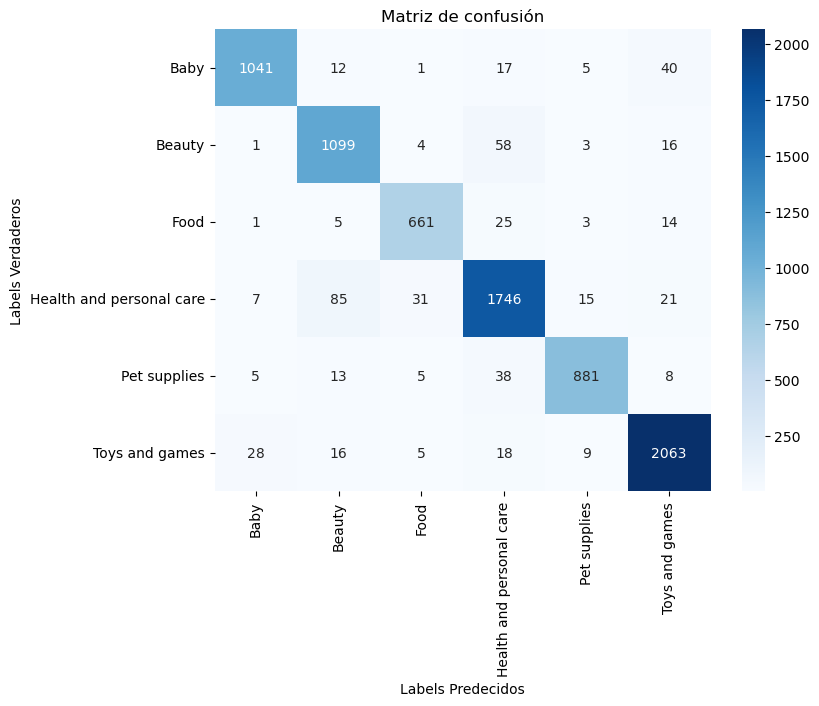

In [55]:
# Calcular y visualizar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Labels Predecidos')
plt.ylabel('Labels Verdaderos')
plt.title('Matriz de confusión')
plt.show()

### Entrenamiento de DistrilBERT  con 2 épocas

In [59]:
training_args_1 = TrainingArguments(              
    num_train_epochs=2,                               # Número de épocas a 1
    per_device_train_batch_size=8,                    # Tamaño del lote por dispositivo de entrenamiento
    per_device_eval_batch_size=8,                     # Tamaño del lote por dispositivo de evaluación
    warmup_steps=500,                                 # Número de pasos para el calentamiento del aprendizaje
    weight_decay=0.01                                 # Factor de decaimiento del peso para la regularización
)

In [60]:
# Inicialización del modelo y del Trainer
model_1 = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))
optimizer_1 = AdamW(model.parameters(), lr=5e-5)  # Optimizador AdamW
trainer_1 = Trainer(
    model=model_1,                                # Modelo a entrenar
    args=training_args_1,                         # Configuración de entrenamiento
    train_dataset=train_dataset,                  # Conjunto de datos de entrenamiento
    eval_dataset=val_dataset                      # Conjunto de datos de evaluación
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# Entrenar el modelo
trainer_1.train()

Step,Training Loss
500,1.076700
1000,0.523200
1500,0.436700
2000,0.406300
2500,0.357400
3000,0.297400
3500,0.318100
4000,0.279700
4500,0.169900
5000,0.187100


TrainOutput(global_step=8000, training_loss=0.30699079751968383, metrics={'train_runtime': 14587.7994, 'train_samples_per_second': 4.387, 'train_steps_per_second': 0.548, 'total_flos': 1738758631680000.0, 'train_loss': 0.30699079751968383, 'epoch': 2.0})

In [62]:
trainer_1.evaluate()  # Evaluar el modelo en el conjunto de datos de evaluación

# Obtener las métricas del resultado de la evaluación
eval_metrics_1 = trainer_1.evaluate()

# Imprimir las métricas
print(eval_metrics_1)

{'eval_loss': 0.2334640622138977, 'eval_runtime': 562.6211, 'eval_samples_per_second': 14.219, 'eval_steps_per_second': 1.777, 'epoch': 2.0}


In [67]:
# Obtener las predicciones del modelo para el conjunto de datos de evaluación
predictions_1 = trainer_1.predict(val_dataset)
predicted_labels_1 = predictions_1.predictions.argmax(axis=1)
true_labels_1 = val_labels_encoded

In [68]:
# Calcular el reporte de clasificación
print("Classification Report:")
print(classification_report(true_labels_1, predicted_labels_1, target_names=categories))

Classification Report:
                          precision    recall  f1-score   support

                    Baby       0.98      0.95      0.96      1116
                  Beauty       0.93      0.93      0.93      1181
                    Food       0.95      0.94      0.94       709
Health and personal care       0.93      0.95      0.94      1905
            Pet supplies       0.96      0.95      0.96       950
          Toys and games       0.97      0.97      0.97      2139

                accuracy                           0.95      8000
               macro avg       0.95      0.95      0.95      8000
            weighted avg       0.95      0.95      0.95      8000



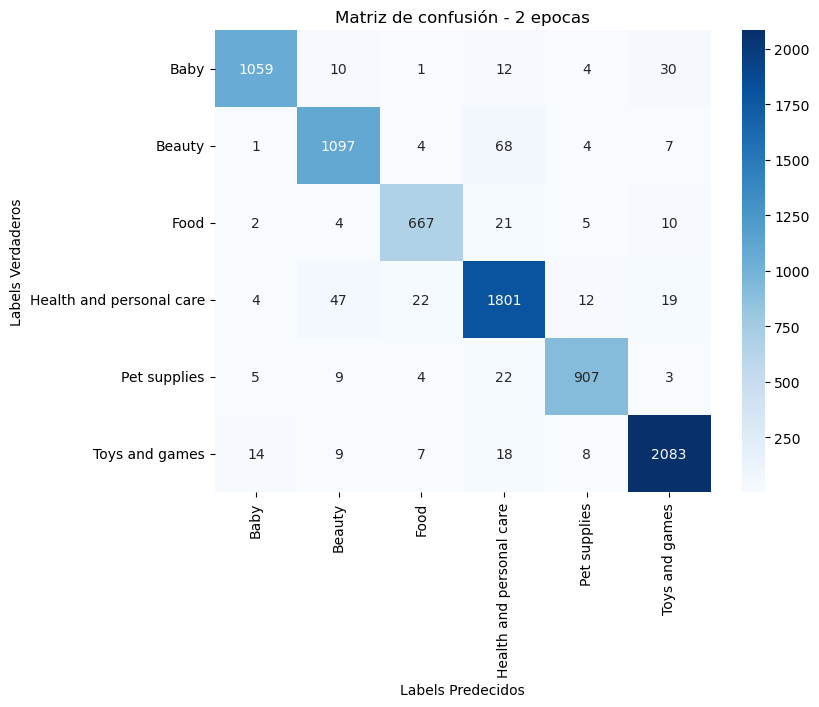

In [69]:
# Calcular y visualizar la matriz de confusión
conf_matrix = confusion_matrix(true_labels_1, predicted_labels_1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Labels Predecidos')
plt.ylabel('Labels Verdaderos')
plt.title('Matriz de confusión - 2 epocas')
plt.show()

In [70]:
# Guardar modelo y tokenizador
model_1.save_pretrained("categorizationModel_1/model_distilbert")
tokenizer.save_pretrained("categorizationModel_1/tokenizer_distilbert")

('categorizationModel_1/tokenizer_distilbert\\tokenizer_config.json',
 'categorizationModel_1/tokenizer_distilbert\\special_tokens_map.json',
 'categorizationModel_1/tokenizer_distilbert\\vocab.txt',
 'categorizationModel_1/tokenizer_distilbert\\added_tokens.json')